## imports

In [1]:
from time import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pathlib import Path
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image, resize, to_tensor
from torchvision.transforms.functional import normalize
# from tqdm.notebook import tqdm
import os
import random

## Data 

In [2]:
# data import and management

def load_mnist(img_size=32):
    ''' returns data and labels for train and test mnist dataset '''
    #---------------- train data -------------------
    mnist_train = datasets.MNIST('data', train=True, download=True)
    data_train = mnist_train.data
    labels_train = [mnist_train[i][1] for i in range(len(data_train))]

    pics = []
    for pic in data_train:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size)     # Resize image if needed
        pic = to_tensor(pic)                # Tensor conversion normalizes in [0,1]
        pics.append(pic)
    data_train = torch.stack(pics)

    #------------------  test data -----------------------
    mnist_test = datasets.MNIST('data', train=False, download=True)
    data_test = mnist_test.data
    labels_test = [mnist_test[i][1] for i in range(len(data_test))]

    pics = []
    for pic in data_test:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size)     # Resize image if needed
        pic = to_tensor(pic)                # Tensor conversion normalizes in [0,1]
        pics.append(pic)
    data_test = torch.stack(pics)

    return (data_train,labels_train), (data_test,labels_test)

def query(datafull, nb, bias=0, fav=0):
    ''' returns -nb random samples of -datafull '''
    data, labels = datafull
    idxs = list(range(len(data)))
    l = []
    h, w = data[0][0].shape
    d = torch.empty(nb, 1, h, w)
    if bias == 0:
        indexes = random.sample(idxs, nb) # drawing nb random indexes
    else :
        indexes = []
        for i in range(nb):
            idx = one_query(labels, idxs, bias, fav)
            indexes.append(idx)
            idxs.remove(idx) # to draw only once each index max
    for k, i in enumerate(indexes): # filling our query
        d[k] = data[i]
        l.append(labels[i])
    return d, l

def one_query(labels, idxs, redraws, fav):
    ''' labels : list of labels
        idxs : list of available indexes
        draws an index with a favorite label choice 
        fav : favorite label
        redraws : max nb of random redraws while fav not found
    '''
    lab = -1 
    while lab != fav and redraws >= 0:
        idx = idxs[random.randint(0, len(idxs)-1)]
        lab = labels[idx]
        redraws -= 1
    return idx

def list_to_longtens(l):
    ''' changes a list into torch.long tensor '''
    tens = torch.empty(len(l), dtype=torch.long)  
    for i, lab in enumerate(l):                       
        tens[i] = lab
    return tens

def swap(l, n, m):
    ''' swaps n and m values in l list '''
    return [m if (v==n) else n if (v==m) else v for v in l]


def distribute_data_rd(datafull, distrib, fav_lab=(-1,-1), dish=False, dish_lab=0, gpu=True): 
    '''draws random data on N nodes following distrib
        data, labels : raw data and labels
        distrib : int list, list of nb of data points for each node
        pref_lab : (prefered label, strength of preference (int))
        dish : boolean, if nodes are dishonest 
        dish_lab : 0 to 4, labelisation method

        returns : (list of batches of images, list of batches of labels)
    '''
    data, labels = datafull
    N = len(distrib)
    data_dist = []      # list of len N
    labels_dist = []    # list of len N
    fav, strength = fav_lab

    for n, number in enumerate(distrib): #for each node
        if fav == -1:  # if no preference
            d, l = query(datafull, number)
        else:
            d, l = query(datafull, number, strength, fav)
        if gpu:
            data_dist.append(torch.FloatTensor(d).cuda())
        else:
            data_dist.append(torch.FloatTensor(d))
        if dish:                # if dishonest node

            # labels modification
            if dish_lab == 0: # random
                tens = torch.randint(10,(number,), dtype=torch.long)
            elif dish_lab == 1: # zeros
                tens = torch.zeros(number, dtype=torch.long)
            elif dish_lab == 2: # swap 1-7
                l = swap(l, 1, 7)
                tens = list_to_longtens(l)
            elif dish_lab == 3: # swap 2 random (maybe same)
                n, m = random.randint(0,10), random.randint(0,10)
                l = swap(l, n, m)
                tens = list_to_longtens(l)
            elif dish_lab == 4: # label +1
                tens = (list_to_longtens(l) + 1) % 10

        else:           # if honest node 
            tens = list_to_longtens(l) # needed for CrossEntropy later
        if gpu:
            tens = tens.cuda()
        labels_dist.append(tens)

    return data_dist, labels_dist 

##model

In [3]:
#model structure

# def get_classifier():
#     ''' returns linear baseline classifier '''
#     model = nn.Sequential( 
#         nn.Flatten(),
#         nn.Linear(1024, 10),
#         nn.Sigmoid()
#         )
#     return model

# def get_classifier():
#     ''' returns classifier '''
#     chan = 16
#     model = nn.Sequential( 
#         nn.Conv2d(1, chan, kernel_size=3, padding=0),
#         nn.Flatten(),
#         nn.Linear(900 * chan, 10),
#         nn.Sigmoid()
#         )
#     return model

class classifier(nn.Module):
    '''CNN Model'''
    def __init__(self):
        super(classifier, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16,
                              kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, 
                              kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()      
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 6 * 6, 10) 
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)  
        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        #Flatten
        out = out.view(out.size(0), -1)
        #Dense
        out = self.fc1(out)
        return out
def get_classifier():
    return classifier()

## Training

### losses

In [4]:
#loss and scoring functions 

def local_loss(model_loc, x, y):  
    ''' classification loss '''
    loss = nn.CrossEntropyLoss()
    predicted = model_loc(x)
    local = loss(predicted,y)
    return local

def generalisation_loss(model_loc, model_glob, pow):  
    ''' l1 distance between global and local parameter
    will be mutliplied by w_n 
    '''
    q, p = pow
    l1_norm = sum(((theta-rho)**q).abs().sum() for theta, rho in 
                  zip(model_loc.parameters(), model_glob.parameters()))**p
    return l1_norm

def regularisation_loss(model_glob, pow): 
    ''' l2 squared regularisation of global parameter
     will be multiplied by w_0 
     '''
    q, p = pow
    l2_sqr = sum((param**q).abs().sum() for param in model_glob.parameters())**p
    return l2_sqr

def round_loss(tens): 
    '''from an input scalar tensor returns rounded integer'''
    if type(tens)==int or type(tens)==float:
        return int(tens)
    else:
        return int(tens.item())

def tens_count(tens, val):
    ''' counts nb of -val in tensor -tens '''
    return len(tens) - round_loss(torch.count_nonzero(tens-val))

def score(model, datafull):
    ''' returns accuracy provided models, images and GTs '''
    out = model(datafull[0])
    predictions = torch.max(out, 1)[1]
    c=0
    for a, b in zip(predictions, datafull[1]):
        c += int(a==b)
    return c/len(datafull[0])

### Flower

In [95]:
#nodes repartition

class Flower():
    ''' Training structure including local models and general one 
        Computing only the part of loss used at each epoch
        Allowing to add and remove nodes at will
        .pop
        .add_nodes
        .rem_nodes
        .train
        .display
        .check
    '''

    def __init__(self, datafull_test, w_0, gpu=True):
        ''' opt : optimizer
            datafull_test : test data couple (imgs,labels)
            w_0 : regularisation strength
        '''
        
        self.d_test = datafull_test
        self.w = w_0
        self.gpu = gpu

        self.opt = optim.Adam
        self.lr_node = 0.001
        self.lr_gen = 0.001
        self.gen_freq = 1  # generalisation frequency (>0) 
        if self.gpu:
            self.general_model = get_classifier().cuda() 
        else:
            self.general_model = get_classifier() 
        self.opt_gen = self.opt(self.general_model.parameters(), lr=self.lr_gen)
        self.pow_gen = (1,1)  # choice of norms for Licchavi loss 
        self.pow_reg = (2,1)  # (internal power, external power)
        self.data = []
        self.labels = [] 
        self.typ = []
        self.models = []
        self.W = []
        self.age = []
        self.opt_nodes = []
        self.nb_nodes = 0
        self.dic = {"honest" : -1, "trolls" : 0, "zeros" : 1, 
                    "one_evil" : 2, "strats" : 3, "jokers" : 4, "byzantine" : -1}
        self.history = ([], [], [], []) # fit, gen, reg, acc
        self.localtest = ([], []) # (which to pick for each node, list of (data,labels) pairs)

    # ------------ population methods --------------------
    def set_localtest(self, datafull, size, fav_lab, nodes):
        ''' create a local data for some nodes
            datafull : source data
            size : size of test sample
            fav_labs : (label, strength)
            nodes : list of nodes which use this data           
        '''
        dt, lb = distribute_data_rd(datafull, [size], fav_lab,
                                    dish=False, dish_lab=0, gpu=self.gpu)
        dtloc = (dt[0], lb[0])
        self.localtest[1].append(dtloc)
        id = len(self.localtest[1]) - 1
        for n in nodes:
            self.localtest[0][n] = id

    def add_nodes(self, datafull, pop, typ, fav_lab=(-1,-1), w=0.01):
        ''' adds nodes to the Flower 
            datafull : data to put on node (sampled from it)
            pop : (nb of nodes, size of nodes)
            typ : type of nodes (str keywords)
            fav_lab : (favorite label, strength)
            w : int, weight of new nodes
        '''
        nb, size = pop
        id = self.dic[typ]
        dish = (id != -1) # boolean for dishonesty
        dt, lb = distribute_data_rd(datafull, [size] * nb, fav_lab,
                                    dish, dish_lab=id, gpu=self.gpu)
        self.data += dt
        self.labels += lb
        self.typ += [typ] * nb
        if self.gpu:
            self.models += [get_classifier().cuda() for i in range(nb)]
        else:
            self.models += [get_classifier() for i in range(nb)]
        self.W += [w] * nb
        self.age += [0] * nb
        for i in range(nb):
            self.localtest[0].append(-1)
        self.nb_nodes += nb
        self.opt_nodes += [self.opt(self.models[n].parameters(), lr=self.lr_node) 
            for n in range(self.nb_nodes - nb, self.nb_nodes) 
            ]
        print("Added {} {} nodes of {} data points".format(nb, typ, size))
        print("Total number of nodes : {}".format(self.nb_nodes))

    def rem_nodes(self, first, last):
        ''' removes nodes of indexes -first (included) to -last (excluded) '''
        nb = last - first
        if last > self.nb_nodes:
            print("-last is out of range, remove canceled")
        else:
            del self.data[first : last]
            del self.labels[first : last] 
            del self.typ[first : last]
            del self.models[first : last]
            del self.W[first : last]
            del self.age[first : last]
            del self.opt_nodes[first : last]
            del self.localtest[0][first : last]
            self.nb_nodes -= nb
            print("Removed {} nodes".format(nb))

    def old(self, years):
        ''' increments age (after training) '''
        for i in range(self.nb_nodes):
            self.age[i] += years
        
    def hm(self, ty):
        ''' counts nb of nodes of this type '''
        return self.typ.count(ty)
    
    def pop(self):
        ''' returns dictionnary of population '''
        c = {}
        for ty in self.dic.keys():
            c[ty] = self.hm(ty)
        return c

    # ------------- scoring methods -----------
    def score_glob(self, datafull): 
        ''' returns accuracy provided images and GTs '''
        return score(self.general_model, datafull)
    
    def test_loc(self, node):
        ''' score of node on local test data '''
        id_data = self.localtest[0][node]
        if id_data == -1:
            # print("No local test data")
            return None
        else:
            nodetest = score(self.models[node], self.localtest[1][id_data])
            return nodetest

    def test_full(self, node):
        ''' score of node on global test data '''
        return score(self.models[node], self.d_test)

    def test_train(self, node):
        ''' score of node on its train data '''
        return score(self.models[node], (self.data[node], self.labels[node]))

    def display(self, node):
        ''' displays accuracy for selected node
            node = -1 for global model
        '''
        if node == -1: # global model
            print("global model")
            print("accuracy on test data :", 
                  self.score_glob(self.d_test))
        else: # we asked for a node
            loc_train = self.test_train(node)
            loc_test = self.test_loc(node)
            full_test = self.test_full(node)
            print("node number :", node, ", dataset size :",
                len(self.labels[node]), ", type :", self.typ[node], 
                ", age :", self.age[node])
            print("accuracy on local train data :", loc_train)
            print("accuracy on local test data :", loc_test)
            print("accuracy on global test data :", full_test)
            repart = {str(k) : tens_count(self.labels[node], k) 
                for k in range(10)}
            print("labels repartition :", repart)

    # --------------------   TRAINING -------------------      
    def train(self, nb_epochs=10, test_freq=1):   
        '''training loop'''
        time_train = time()

        for n in range(self.nb_nodes):  # updating lr in optimizers
            self.opt_nodes[n].param_groups[0]['lr'] = self.lr_node
        self.opt_gen.param_groups[0]['lr'] = self.lr_gen

        # initialisation to avoid undefined variables
        loss = 0
        fitting_loss = 0
        harmonisation_loss = 0 
        regul_loss = 0
        count_fit, count_gen = 0, 0
        
        for epoch in range(1, nb_epochs+1):
            time_ep1 = time()

            # fitting or general epoch?
            fit_epoch = (count_fit >= count_gen) 
            if fit_epoch:
                count_gen += self.gen_freq
            else:
                count_fit += 1              
            print("epoch :",epoch,'/',nb_epochs, 
                  "(fit)" if fit_epoch else "(gen)")

            #   only one step because we use all data at every epoch
            # for step in range(1): 
            for n in range(self.nb_nodes):
                self.opt_nodes[n].zero_grad()      
            self.opt_gen.zero_grad()


            #----------------    Licchavi loss  -------------------------
            if fit_epoch: # only first 2 terms of loss updated
                fitting_loss = 0
                harmonisation_loss = 0 
                diff = 0  # used to print correct loss
                for n in range(self.nb_nodes):   # for each node
                    if self.typ[n] == "byzantine":
                        fit = local_loss(self.models[n], 
                                               self.data[n], self.labels[n])
                        fitting_loss -= fit
                        diff += 2 * fit
                    else:
                        fitting_loss += local_loss(self.models[n], 
                                               self.data[n], self.labels[n])
                    g = generalisation_loss(self.models[n], 
                                            self.general_model, self.pow_gen)
                    harmonisation_loss +=  self.W[n] * g  # generalisation term   
                loss = fitting_loss + harmonisation_loss         

            else: # only last 2 terms of loss updated        
                harmonisation_loss = 0 
                regul_loss = 0
                for n in range(self.nb_nodes):   # for each node
                    g = generalisation_loss(self.models[n], 
                                            self.general_model, self.pow_gen)
                    harmonisation_loss += self.W[n] * g  #generalisation term    
                r = regularisation_loss(self.general_model, self.pow_reg) 
                regul_loss = self.w * r   # regul term  
                loss = harmonisation_loss + regul_loss

            total_out = round_loss(fitting_loss + diff
                  + harmonisation_loss + regul_loss)
            print("total loss : ", total_out)  # printing losses
            print("fitting : ", round_loss(fitting_loss + diff),
                  ', harmonisation : ', round_loss(harmonisation_loss),
                  ', regularisation : ', round_loss(regul_loss))
            
            self.history[0].append(round_loss(fitting_loss))
            self.history[1].append(round_loss(harmonisation_loss))
            self.history[2].append(round_loss(regul_loss)) 

            # ---------------------   Gradient descent ---------------------
            loss.backward()      # backpropagation
            if fit_epoch:       # updating local or global alternatively
                for n in range(self.nb_nodes): 
                    self.opt_nodes[n].step()      # updating nodes weights 
            else:
                self.opt_gen.step()       # updating general weights

            time_ep2 = time()
            print("epoch time :", round(time_ep2 - time_ep1, 2))

            if epoch % test_freq == 0:   # printing accuracy on test data
                acc = self.score_glob(self.d_test)
                print("\nTEST ACCURACY : ", acc)
                for i in range(test_freq):
                    self.history[3].append(acc) 
            
            self.old(1)  # aging all nodes
            if False and not fit_epoch: # TEMPORARY adds nodes between epochs
                roll = 100
                self.add_nodes(train, (roll, 100), "honest", w=0.1)
                self.rem_nodes(0, 0 + roll)
            
            print("\n")      # epoch end

        # ----------------- end of training -------------------------------    
        
        for i in range(nb_epochs % test_freq): # to maintain same history length
            self.history[3].append(acc)
        print("training time :", round(time() - time_train, 2)) 
    
    def check(self):
        ''' performs some tests on internal parameters adequation '''
        b1 =  (self.nb_nodes == len(self.data) == len(self.labels) 
            == len(self.typ) == len(self.models) == len(self.opt_nodes) 
            == len(self.W) == len(self.age) == len(self.localtest[0]))
        b2 = (len(self.history[0]) == len(self.history[1]) 
            == len(self.history[2]) == len(self.history[3]) >= max(self.age))
        b3 = (max(self.localtest[0]) <= len(self.localtest[1]) - 1)
        if (b1 and b2 and b3):
            print("No Problem")
        else:
            print("OULALA non ça va pas là")
        

## get data

In [ ]:
# downloading data
if 'train' not in globals(): # to avoid loading data every time
    train, test = load_mnist()
    test_gpu = torch.tensor(test[0]).cuda(), torch.tensor(test[1]).cuda()

## getting plots

In [ ]:
# functions to display training history 
def show_loss(flow, title=None):
    ''' plots curves of loss evolution of a Flower '''
    fit, gen, reg, _ = flow.history
    tot = [a + b + c for a, b, c in zip(fit, gen, reg)]
    epochs = range(1,len(fit))
    plt.plot(epochs, fit[1:],label='fit')
    plt.plot(epochs, gen[1:],label='gen')
    plt.plot(epochs, reg[1:],label='reg')      #outputs results as a plot
    plt.plot(epochs, tot[1:],label='tot')
    if title is not None:
        plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def show_acc(flow, title=None):
    '''' plots curves of accuracy evolution of a Flower '''
    acc = flow.history[3]
    epochs = range(1,len(acc))
    plt.plot(epochs, acc[1:],label='acc')
    plt.ylim([0,1])
    if title is not None:
        plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.legend()
    plt.show()

In [115]:
# functions to train and display history at the end
def run_disp(nbn, gpu=True):
    ''' creates a flower of honest nodes and trains it for 200 eps
        displays graphs of loss and accuracy 
        nbn : number of nodes
    '''
    w = 0.05 * nbn
    if gpu:
        flow = Flower(test_gpu, w, gpu=gpu)
    else:
        flow = Flower(test, w, gpu=gpu)
    ppn = 60_000 // nbn # points per node
    flow.add_nodes(train, (nbn, ppn), "honest", w=0.005)

    epochs = 200
    flow.lr_node = 0.001
    flow.lr_gen = 0.01
    flow.gen_freq = 1
    flow.train(epochs, test_freq=2)
    flow.check()
    text = "nbn : {}, ppn : {}, lrnode : {}, lrgen : {}, genfrq : {}, eps :{}"
    title = text.format(nbn, ppn, flow.lr_node, 
                        flow.lr_gen, flow.gen_freq, epochs)
    show_acc(flow, title)
    show_loss(flow, title)    
    return flow

def run_fracbyz(frac, typ, gpu=True):
    ''' creates a flower of honest nodes and trains it for 200 eps
        displays graphs of loss and accuracy 
        frac : fraction of dishonest nodes
    '''
    nbn = 1000
    w = 0.05 * nbn
    if gpu:
        flow = Flower(test_gpu, w, gpu=gpu)
    else:
        flow = Flower(test, w, gpu=gpu)
    ppn = 60_000 // nbn # points per node
    nbbyz = int(frac * nbn)
    nbh = nbn - nbbyz
    
    flow.add_nodes(train, (nbh, ppn), "honest", w=0.005)
    flow.add_nodes(train, (nbbyz, ppn), typ, w=0.005)


    epochs = 200
    flow.lr_node = 0.001
    flow.lr_gen = 0.01
    flow.gen_freq = 1
    flow.train(epochs, test_freq=2)
    flow.check()
    text = "frac : {}, nbn : {}, lrnode : {}, lrgen : {}, genfrq : {}, eps :{}"
    title = text.format(frac, nbn, flow.lr_node, 
                        flow.lr_gen, flow.gen_freq, epochs)
    show_acc(flow, title)
    show_loss(flow, title)    
    return flow

def run_heter(heter, frac=0, typ="zeros", gpu=True):
    ''' creates a flower of honest nodes and trains it for 200 eps
        displays graphs of loss and accuracy 
        frac : fraction of dishonest nodes
        heter : heterogeneity of data
    '''
    nbn = 1000
    w = 0.05 * nbn
    if gpu:
        flow = Flower(test_gpu, w, gpu=gpu)
    else:
        flow = Flower(test, w, gpu=gpu)
    ppn = 60_000 // nbn # points per node
    nbbyz = int(frac * nbn)
    nbh = nbn - nbbyz
    nbh_lab = nbh // 10 # for each label
    nbbyz_lab = nbbyz // 10
    
    for lab in range(10):
        flow.add_nodes(train, (nbh_lab, ppn), "honest", (lab, heter), w=0.005)
        flow.add_nodes(train, (nbbyz_lab, ppn), typ, (lab, heter), w=0.005)

    epochs = 200
    flow.lr_node = 0.001
    flow.lr_gen = 0.01
    flow.gen_freq = 1
    flow.train(epochs, test_freq=2)
    flow.check()
    t1 = "heter : {}, nbn : {}, lrnode : {}, lrgen : {}, genfrq : {}, eps :{}" 
    t2 = "\nfrac : {}, type : " + typ 
    text = t1 + t2
    title = text.format(heter, nbn, flow.lr_node, 
                        flow.lr_gen, flow.gen_freq, epochs, frac)
    show_acc(flow, title)
    show_loss(flow, title)    
    return flow

In [ ]:
flowheter = run_heter(20, frac=0.2, typ="byzantine")

Added 80 honest nodes of 60 data points
Total number of nodes : 80
Added 20 byzantine nodes of 60 data points
Total number of nodes : 100
Added 80 honest nodes of 60 data points
Total number of nodes : 180
Added 20 byzantine nodes of 60 data points
Total number of nodes : 200
Added 80 honest nodes of 60 data points
Total number of nodes : 280
Added 20 byzantine nodes of 60 data points
Total number of nodes : 300
Added 80 honest nodes of 60 data points
Total number of nodes : 380
Added 20 byzantine nodes of 60 data points
Total number of nodes : 400
Added 80 honest nodes of 60 data points
Total number of nodes : 480
Added 20 byzantine nodes of 60 data points
Total number of nodes : 500
Added 80 honest nodes of 60 data points
Total number of nodes : 580
Added 20 byzantine nodes of 60 data points
Total number of nodes : 600
Added 80 honest nodes of 60 data points
Total number of nodes : 680
Added 20 byzantine nodes of 60 data points
Total number of nodes : 700
Added 80 honest nodes of 60 

#manual

In [96]:
tulip = Flower(test_gpu, 0.01)

In [98]:
tulip.add_nodes(train, (90, 600), "honest", w=0.005)
tulip.add_nodes(train, (10, 600), "honest", (0,10), w=0.005)
tulip.set_localtest(test, 1000, (-1,-1), range(0,50))
tulip.set_localtest(test, 1000, (0,10), range(50,100))
tulip.check()

Added 90 honest nodes of 600 data points
Total number of nodes : 190
Added 10 honest nodes of 600 data points
Total number of nodes : 200


In [103]:
tulip.display(57)

node number : 57 , dataset size : 600 , type : honest , age : 0
accuracy on local train data : 0.09166666666666666
accuracy on local test data : 0.053
accuracy on global test data : 0.0953
labels repartition : {'0': 67, '1': 67, '2': 59, '3': 65, '4': 57, '5': 56, '6': 59, '7': 59, '8': 51, '9': 60}


In [ ]:
tulip.w = 5
tulip.lr_node = 0.001
tulip.lr_gen = 0.01
tulip.gen_freq = 1
tulip.train(100, test_freq=10)
tulip.check()

###display 

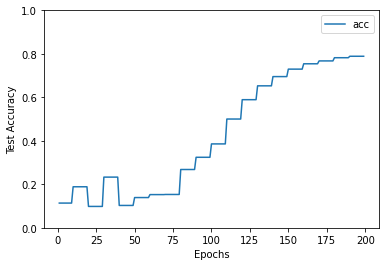

In [67]:
show_acc(tulip)

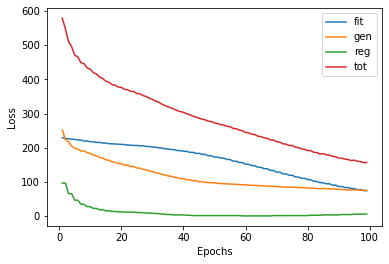

In [58]:
show_loss(tulip)

# Brouillon

In [ ]:
def destroy(obj):   
    del obj
    torch.cuda.empty_cache()